In [1]:
import wandb
import yaml
from utilities.utils import correct_type_of_entry
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from copy import deepcopy

/Users/mathieubazinet/.pyenv/versions/3.12.3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
dataset = "mnist"
#[0, 1, 2, 4, 5, -1]
#[8, 7, 3, 9, 6, -1]
first_class = 4
second_class = 9
sweep_config = "default"
values_to_fetch = ['kl_bound', 'binomial_approximation_shah', 'p2l_bound', 'compression_set_size', 'validation_error', 'test_error']

In [4]:
sweep_config_name = "./configs/sweep_configs/" + sweep_config + ".yaml"
with open(sweep_config_name) as file:
    sweep_configuration = yaml.safe_load(file)
    
hps = {}
for key, item in sweep_configuration['parameters'].items():
    if item.get('values', None) is not None:
        hps[key] = correct_type_of_entry(item['values'])
size_hyperparams = tuple([len(l) for l in hps.values()])

In [5]:
api = wandb.Api(timeout=29)
entity = "mathieu-bazinet"
project = "sweep" + dataset + str(first_class) + str(second_class)
runs = api.runs(entity + "/" + project)

In [6]:
results_matrix = np.ones(((len(values_to_fetch),) + size_hyperparams))

for run_idx in range(len(runs)):
    run = runs[run_idx]
    for val_to_fetch_idx in range(len(values_to_fetch)):
        matrix_idx = tuple([val_to_fetch_idx] + [hps[key].index(run.config[key]) for key in hps.keys()])
        val_to_fetch = values_to_fetch[val_to_fetch_idx]
        results_matrix[matrix_idx] = run.summary[val_to_fetch]

In [7]:
from itertools import product

hp_list = list(hps.values())[1:]
params_product = list(product(*hp_list))
name_list = []
idx_list = []
for params in params_product:
    name = ""
    for p in params:
        name += str(p) + " "
    name_list.append(name[:-1])
    idx = ()
    for p_idx in range(len(params)):
        p_key = list(hps.keys())[1:][p_idx]
        idx += (hps[p_key].index(params[p_idx]),)
    idx_list.append(tuple(idx))

def different_length_means(list_of_list):
    mean_list = []
    for idx in range(max([len(l) for l in list_of_list])):
        count = 0
        somme = 0
        for l in list_of_list:
            if len(l) > idx:
                somme += l[idx]
                count += 1
        mean_list.append(somme/count)
    return np.array(mean_list)

In [8]:
reshaped_matrix = results_matrix.mean(1).reshape(results_matrix.shape[0],np.prod(results_matrix.shape[2:])).T
mean_df = pd.DataFrame(reshaped_matrix, index=name_list, columns=values_to_fetch)
mean_df

,kl_bound,binomial_approximation_shah,p2l_bound,compression_set_size,validation_error,test_error
mlp 0.1 0.01,0.224476,0.224062,0.068970,674.8,0.011565,0.011379
mlp 0.1 0.001,0.167632,0.167198,0.046221,445.2,0.010249,0.011511
mlp 0.1 0.005,0.177014,0.176583,0.049706,480.2,0.010892,0.011775
mlp 0.1 0.0001,0.154836,0.154396,0.041627,399.2,0.011124,0.011398
mlp 0.2 0.01,0.228788,0.228376,0.070712,692.4,0.013163,0.011743
mlp 0.2 0.001,0.162551,0.162114,0.044347,426.4,0.011010,0.010216
mlp 0.2 0.005,0.176842,0.176411,0.049665,479.8,0.011683,0.010896
mlp 0.2 0.0001,0.144096,0.143653,0.037846,361.4,0.011862,0.010427
cnn 0.1 0.01,0.169415,0.168981,0.047547,459.0,0.006314,0.007858
cnn 0.1 0.001,0.105158,0.104699,0.025300,237.0,0.008162,0.007712


In [9]:
std_matrix = results_matrix.std(1).reshape(results_matrix.shape[0],np.prod(results_matrix.shape[2:])).T
std_df = pd.DataFrame(std_matrix, index=name_list, columns=values_to_fetch)

std_df

,kl_bound,binomial_approximation_shah,p2l_bound,compression_set_size,validation_error,test_error
mlp 0.1 0.01,0.017215,0.017221,0.007488,75.961569,0.002762,0.001575
mlp 0.1 0.001,0.006531,0.006533,0.002401,24.086511,0.002502,0.000903
mlp 0.1 0.005,0.005592,0.005594,0.002099,21.094075,0.000918,0.001807
mlp 0.1 0.0001,0.008939,0.008942,0.003175,31.764131,0.000973,0.001249
mlp 0.2 0.01,0.009418,0.009422,0.004067,41.243666,0.002755,0.002876
mlp 0.2 0.001,0.001647,0.001647,0.000594,5.953150,0.002201,0.001419
mlp 0.2 0.005,0.008690,0.008693,0.003288,33.053895,0.002402,0.001269
mlp 0.2 0.0001,0.000543,0.000543,0.000186,1.854724,0.003303,0.001008
cnn 0.1 0.01,0.035909,0.035923,0.014277,144.019443,0.002216,0.001676
cnn 0.1 0.001,0.003735,0.003737,0.001123,11.045361,0.001118,0.001745


/var/folders/t7/t2tk8_dd3vsc811yh2mdwbbh0000gp/T/ipykernel_45247/1844805149.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


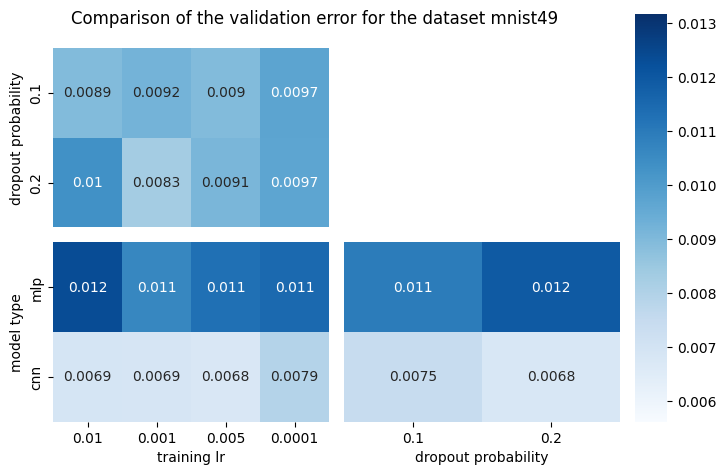

In [10]:
mean_arr = results_matrix.mean(1)
index = 4

fig, axs = plt.subplots(2, 2)
fig.delaxes(axs[0, 1])
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([1, 0.12, 0.05, 0.85])

cmap = 'Blues'
vmax = mean_arr[index].max()
vmin = mean_arr[index].min()

lr_mt_arr = pd.DataFrame(mean_arr.mean(2)[index,:,:], index=hps['model_type'], columns=hps['training_lr'])
lr_dp_arr = pd.DataFrame(mean_arr.mean(1)[index,:,:], index=hps['dropout_probability'], columns=hps['training_lr'])
dp_mt_arr = pd.DataFrame(mean_arr.mean(3)[index,:,:], index=hps['model_type'], columns=hps['dropout_probability'])

sn.heatmap(lr_dp_arr, annot=True,ax=axs[0,0],xticklabels=False, cbar=False, vmin=vmin, vmax=vmax, cmap=cmap)
axs[0,0].set(ylabel="dropout probability")

sn.heatmap(lr_mt_arr, annot=True, ax=axs[1,0], cbar=False, cmap=cmap, vmin=vmin, vmax=vmax,)
axs[1,0].set(xlabel="training lr", ylabel="model type")

sn.heatmap(dp_mt_arr,annot=True, ax=axs[1,1], yticklabels=False, cbar=True, cmap=cmap, cbar_ax=cbar_ax, vmin=vmin, vmax=vmax,)
axs[1,1].set(xlabel="dropout probability")


fig.suptitle(f"Comparison of the {values_to_fetch[index].replace('_', ' ')} for the dataset {dataset + str(first_class) + str(second_class)}")
# Layout so plots do not overlap
fig.tight_layout()

plt.savefig(f"./results/binary_mnist/{dataset}_{first_class}_{second_class}_{values_to_fetch[index]}_heatmaps.jpg",bbox_inches='tight')

In [11]:
val_of_interest = "p2l_bound"
wanted_model_type = "cnn"
model_df = mean_df[[wanted_model_type in idx for idx in mean_df.index]]
std_model_df = std_df[[wanted_model_type in idx for idx in std_df.index]]

model_type, dropout_probability, training_lr = correct_type_of_entry(model_df.index[model_df[val_of_interest].argmin()].split())

print("model type :", model_type, "dropout probability :", dropout_probability, "learning rate :", training_lr)

best_val_arr = model_df.loc[model_df.index[model_df[val_of_interest].argmin()]]
std_val_arr = std_model_df.loc[model_df.index[model_df[val_of_interest].argmin()]]
print(f"Validation error: {best_val_arr['validation_error']:.4f}±{std_val_arr['validation_error']:.4f} "
      f'Test error : {best_val_arr['test_error']:.4f}±{std_val_arr['test_error']:.4f} ', 
      f"KL bound : {best_val_arr['kl_bound']:.4f}±{std_val_arr['kl_bound']:.4f} ",
    f'binomial : {best_val_arr['binomial_approximation_shah']:.4f}±{std_val_arr['binomial_approximation_shah']:.4f} ',
     f'P2L bound : {best_val_arr['p2l_bound']:.4f}±{std_val_arr['p2l_bound']:.4f} ', 
      f'compression set size : {best_val_arr['compression_set_size']:.4f}±{std_val_arr['compression_set_size']:.4f} ')

model type : cnn dropout probability : 0.1 learning rate : 0.001
Validation error: 0.0082±0.0011 Test error : 0.0077±0.0017  KL bound : 0.1052±0.0037  binomial : 0.1047±0.0037  P2L bound : 0.0253±0.0011  compression set size : 237.0000±11.0454 


The best bound for run 42 happens at 130 datapoints with a bound value of 0.08510002505214416
The best bound for run 4 happens at 150 datapoints with a bound value of 0.08629978491669357
The best bound for run 3 happens at 150 datapoints with a bound value of 0.08371392888540359
The best bound for run 2 happens at 130 datapoints with a bound value of 0.07976191415495015
The best bound for run 1 happens at 80 datapoints with a bound value of 0.07274369446808457
Mean value of the best bounds taken separately : 0.0815238694954552
Mean value of the compression size of best bounds : 128.0


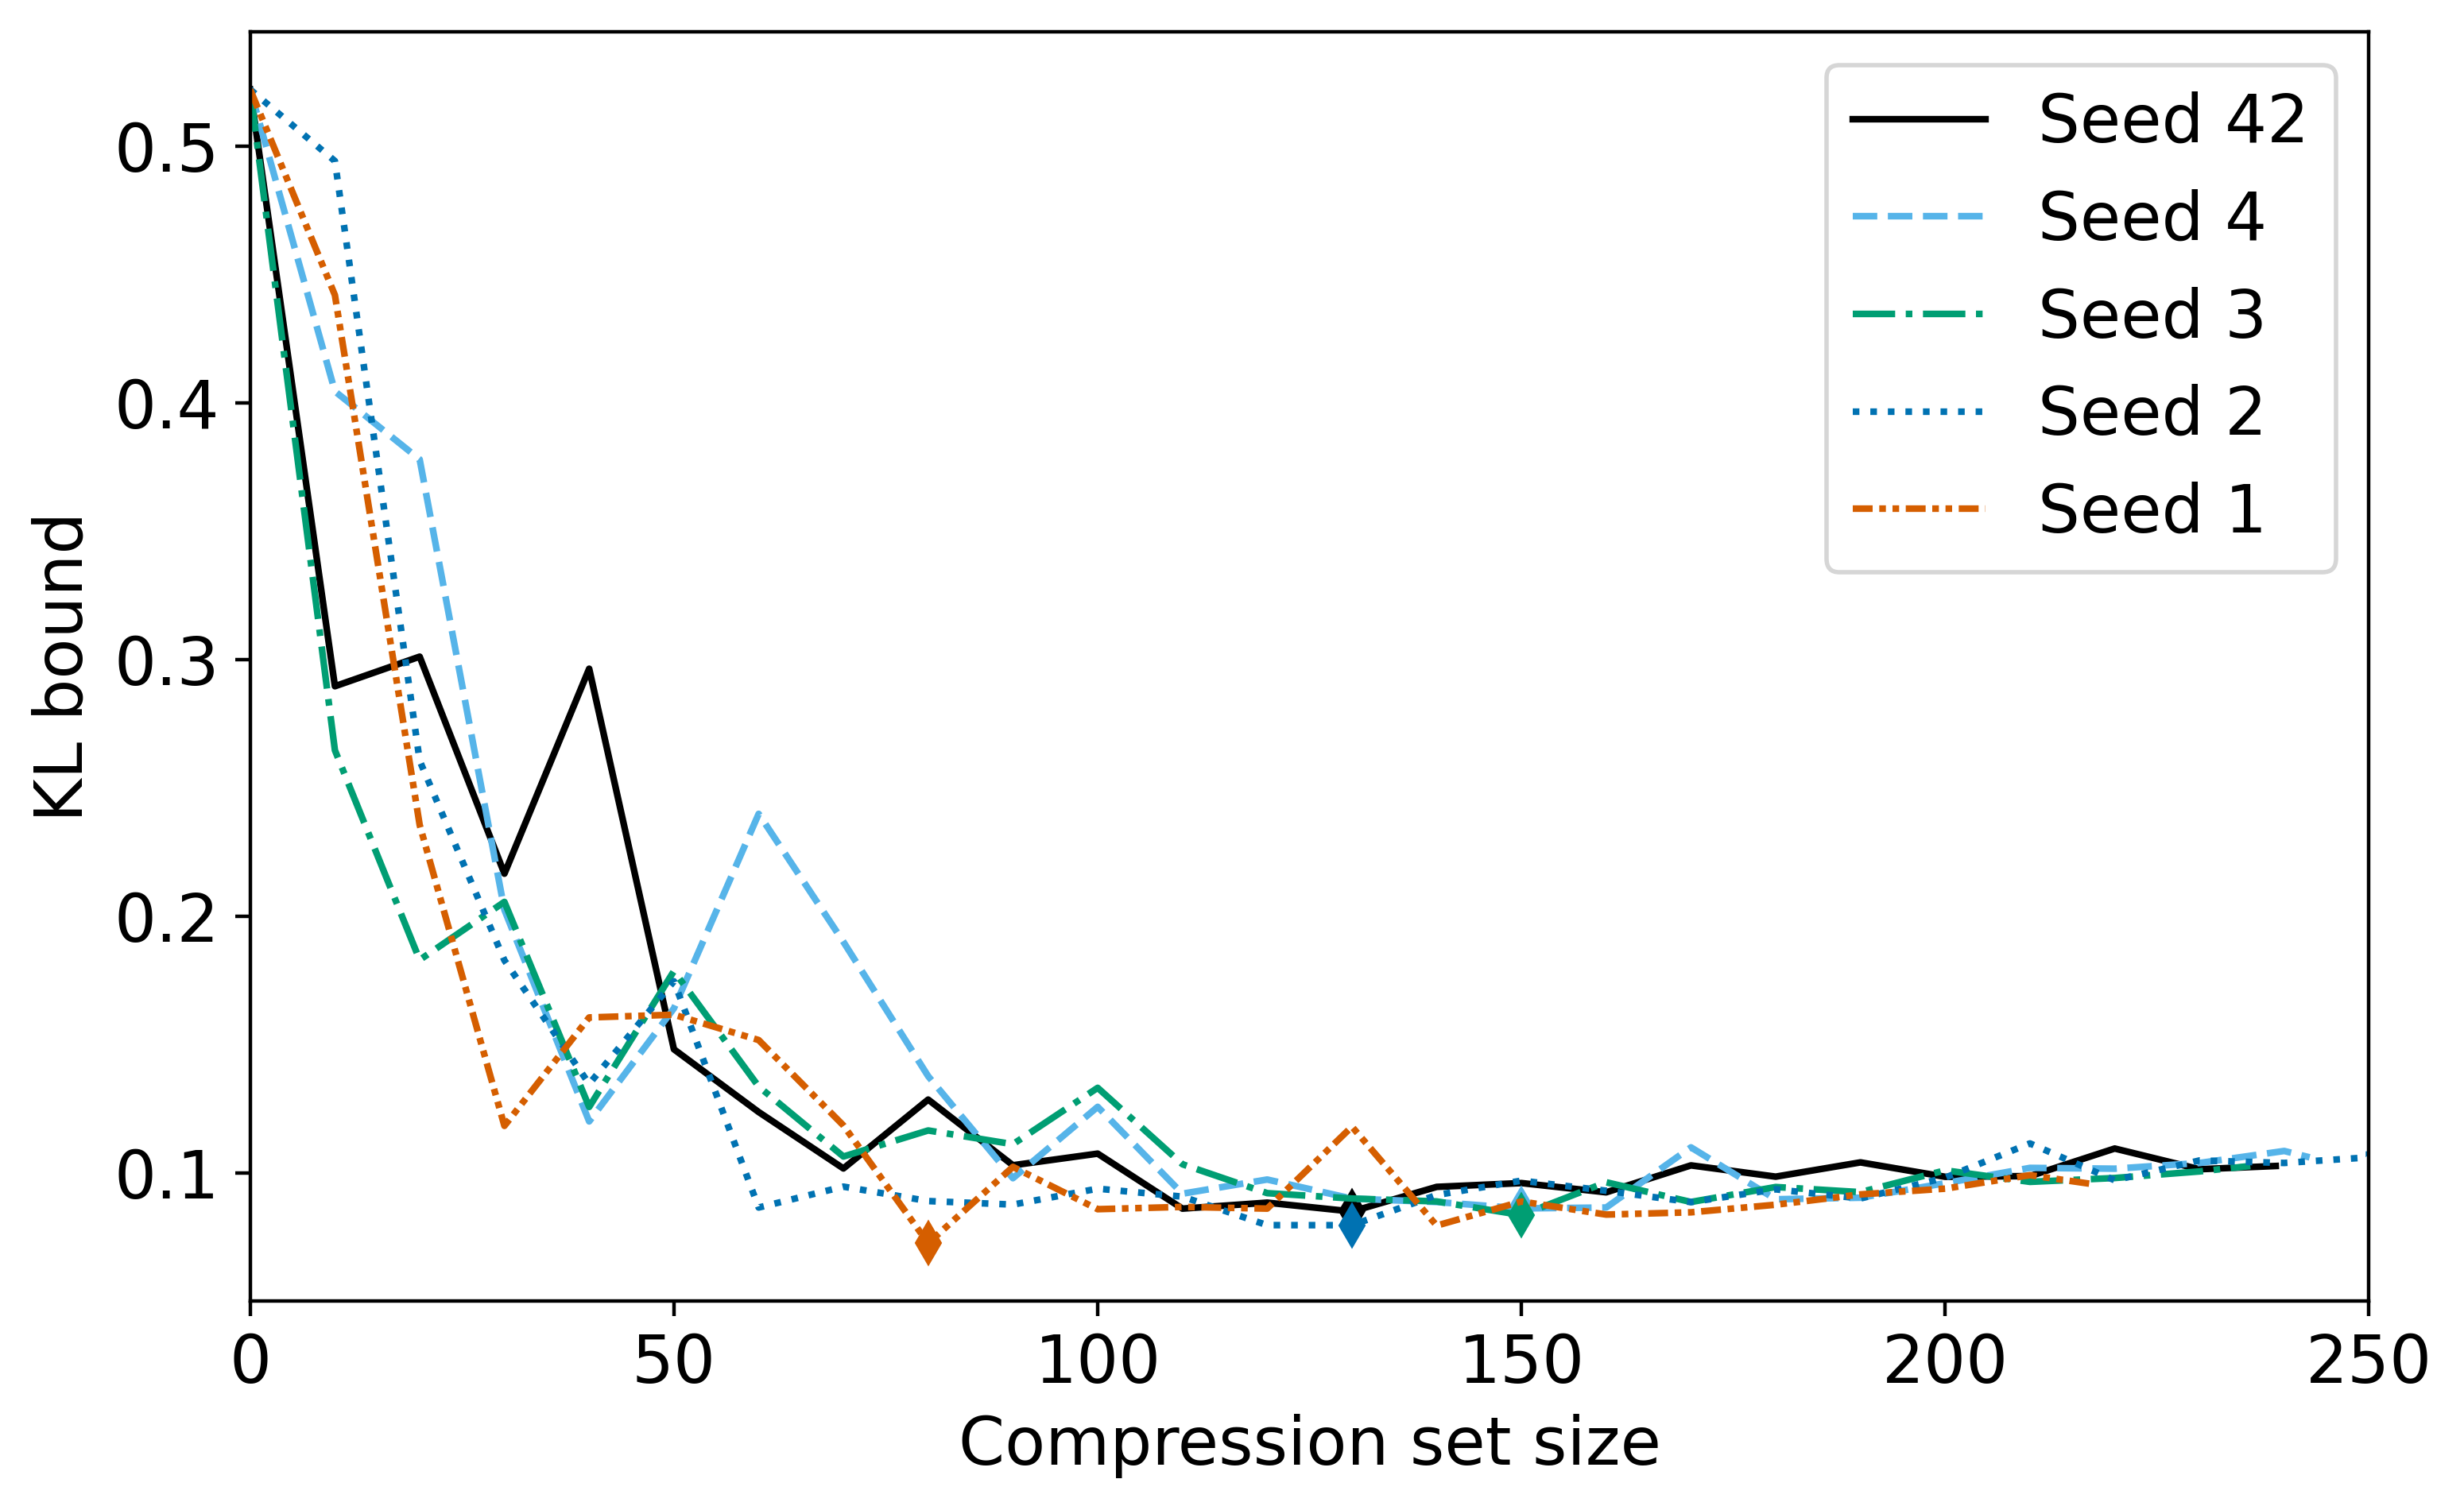

In [46]:
from bounds.real_valued_bounds import compute_epsilon, kl_bound

linestyles = ['-', '--', '-.', ':', (0, (3, 1, 1, 1, 1, 1))]
colors = ["#000000", "#56B4E9", "#009E73", "#0072B2", "#D55E00"]

plt.figure(figsize=(8,5),dpi=400)
run_list = []

for run in runs:
    if run.config['model_type'] == model_type:
        if run.config['training_lr'] == training_lr:
            if run.config['dropout_probability'] == dropout_probability:
                run_list.append(run)

all_seeds_bounds = []
max_comp_sizes = 0
counter = 0
best_comp_set_size = []
for run in run_list:
    history = run.scan_history(keys=["complement_error"])
    losses = [row["complement_error"] for row in history]
    val_sizes = run.config['data_groupsize'] * run.config['log_iterations']
    # compression_sizes = np.array(list(range(1,len(losses)))) * val_sizes
    compression_sizes = np.array(list(range(0,len(losses)))) * val_sizes
    compression_sizes = np.append(compression_sizes, run.summary['compression_set_size'])
        
    if compression_sizes.max() > max_comp_sizes:
        max_comp_sizes = compression_sizes.max()
        
    bound_list = []
    for idx in range(len(losses)):
        epsilon = compute_epsilon(compression_sizes[idx], 1, run.summary['train_set_size'], run.config['delta'])
        bound = kl_bound(compression_sizes[idx], run.summary['train_set_size'], float(losses[idx]), epsilon)
        bound_list.append(bound)

    if dataset + str(first_class) + str(second_class) == "mnist08":
        val_to_add = [0.5221730666235089, 0.5221730666235089, 0.5172915806790146, 0.5305361625840044, 0.5045037777077217][hps['seed'].index(run.config['seed'])]
        bound_list = [val_to_add] +  bound_list
    elif dataset + str(first_class) + str(second_class) == "mnist17":
        val_to_add = [0.5211469745263457, 0.5211469745263457, 0.5211469745263457, 0.5042897517783912, 0.5211469745263457][hps['seed'].index(run.config['seed'])]
        bound_list = [val_to_add] +  bound_list
    elif dataset + str(first_class) + str(second_class) == "mnist23":
        val_to_add = [0.6168213266023356, 0.5219418201057787, 0.5112311835350163, 0.5219418201057787, 0.5219418201057787][hps['seed'].index(run.config['seed'])]
        bound_list = [val_to_add] +  bound_list
    elif dataset + str(first_class) + str(second_class) == "mnist49":
        val_to_add = [0.5221581561490893, 0.5221581561490893,0.5221581561490893,0.5221581561490893,  0.5221581561490893][hps['seed'].index(run.config['seed'])]
        bound_list = [val_to_add] +  bound_list
    elif dataset + str(first_class) + str(second_class) == "mnist56":
        val_to_add = [0.5225730342790484, 0.5598629093475724, 0.5225730342790484, 0.5218771218723198, 0.5225730342790484][hps['seed'].index(run.config['seed'])]
        bound_list = [val_to_add] +  bound_list


    plt.plot(compression_sizes, bound_list,'d',
             markevery=[np.array(bound_list).argmin()],
             linestyle=linestyles[counter], #ms=8, #mew=1.2,
             color=colors[counter],
             # label=f"Seed {run.config['seed']} (min bound : {min(bound_list):.4f})"
             label=f"Seed {run.config['seed']}"
            )
    best_idx = np.array(bound_list).argmin()
    best_comp_set_size.append(compression_sizes[best_idx])
    print(f"The best bound for run {run.config['seed']} happens at {compression_sizes[best_idx]} datapoints with a bound value of {bound_list[best_idx]}")
    all_seeds_bounds.append(bound_list)
    counter += 1

plt.xlabel("Compression set size")
plt.ylabel("KL bound")
plt.xlim(0, max_comp_sizes)
print(f"Mean value of the best bounds taken separately : {sum([min(l) for l in all_seeds_bounds])/5}")
print(f"Mean value of the compression size of best bounds : {sum(best_comp_set_size)/5}")
plt.legend(markerscale=0)
plt.rcParams.update({'font.size': 15})
# plt.title(f"Comparison of the behavior of the bound on {dataset + str(first_class) + str(second_class)}")
plt.tight_layout()
plt.savefig(f"./results/binary_mnist/{dataset}_{first_class}_{second_class}_min_bound_comparison.jpg")


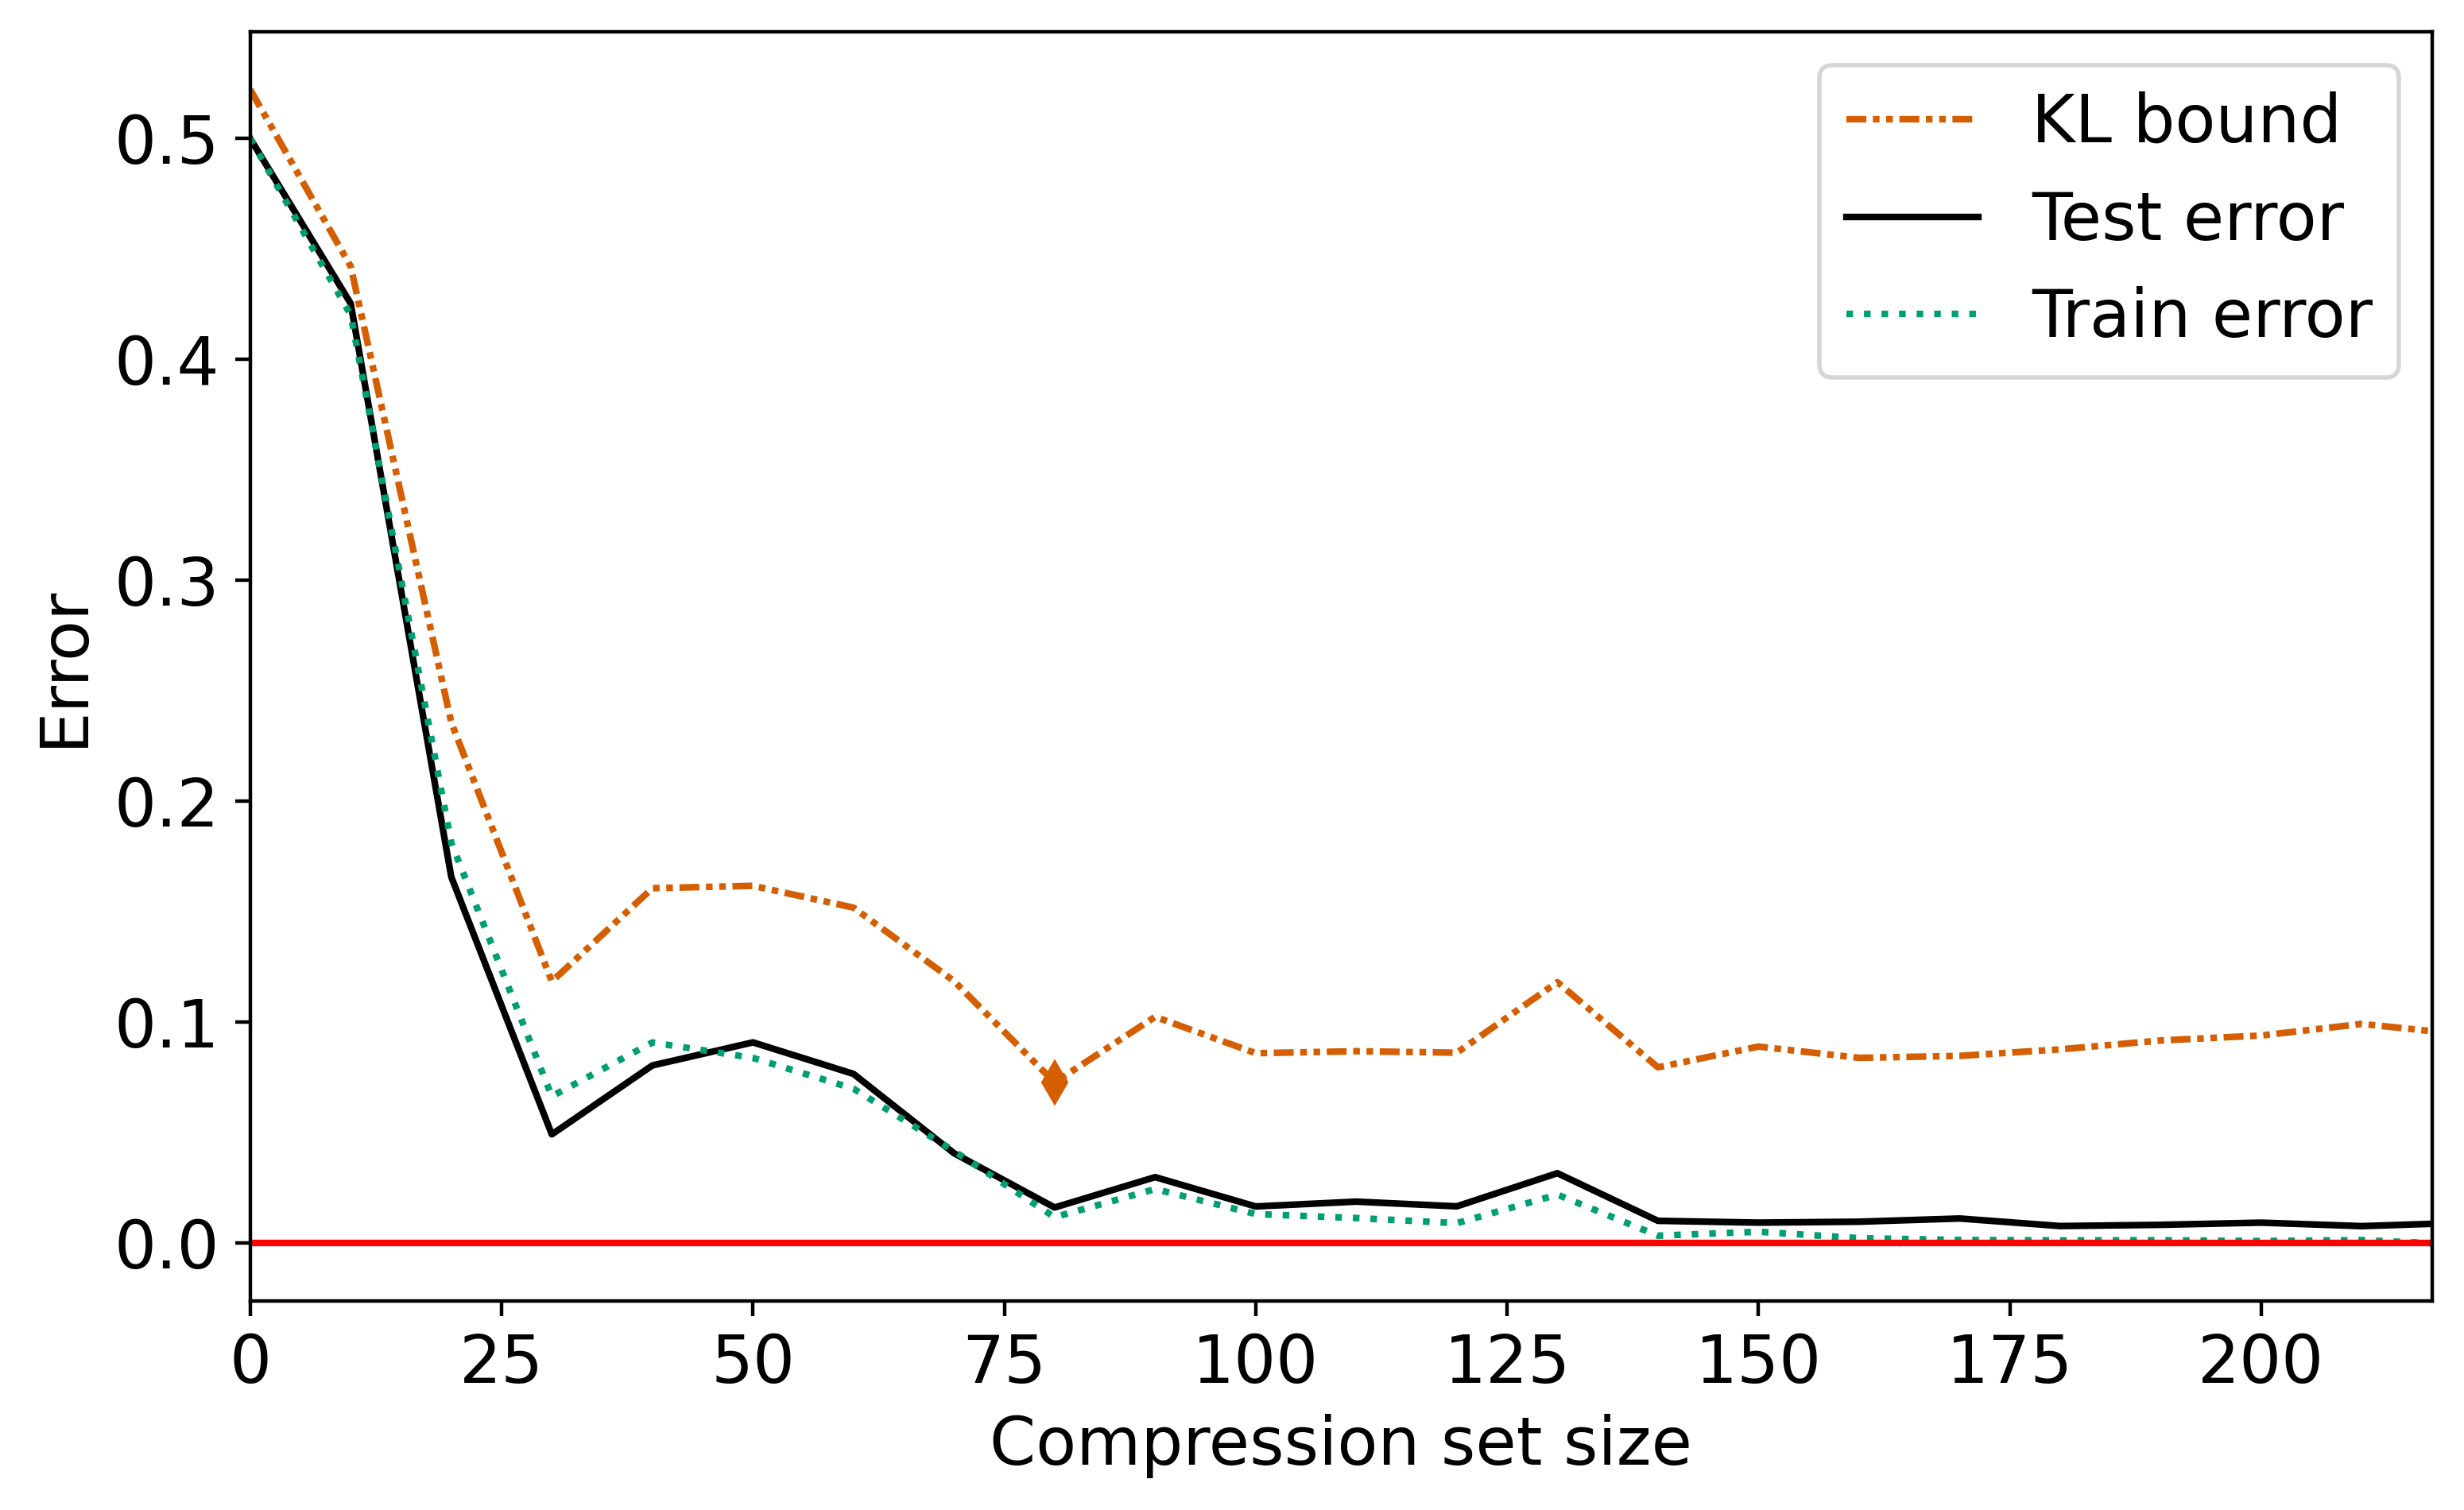

In [66]:
plt.figure(figsize=(8,5),dpi=400)

history_test = run.scan_history(keys=["test_results"])
test_error = [row["test_results"] for row in history_test]
test_error.append(run.summary["test_error"])

plt.plot(compression_sizes, bound_list,'d',
         markevery=[np.array(bound_list).argmin()],
         linestyle=linestyles[4], #ms=8, #mew=1.2,
         color=colors[4],
         label=f"KL bound"
        )

test_error.insert(0, 0.5)
plt.plot(compression_sizes, test_error, linestyle=linestyles[0], color=colors[0], label="Test error")

losses.insert(0, 0.5)
plt.plot(compression_sizes, losses,
         linestyle=linestyles[3],
         color=colors[2], label="Train error")
losses = losses[1:]

plt.xlabel("Compression set size")
plt.ylabel("Error")
plt.xlim(0, max(compression_sizes))
plt.axhline(y=0.0, xmin=0.0, xmax=1.0, color='r')
# plt.ylim(0, 0.55)
plt.legend(markerscale=0)
plt.rcParams.update({'font.size': 15})
plt.tight_layout()
plt.savefig(f"/Users/mathieubazinet/Downloads/mnist49_graph_poster_neurips.jpg")

In [13]:
from bounds.classical_bounds import binomial_approximation
from bounds.bound_utils import zeta, log_binomial_coefficient
from time import sleep

new_vals_to_fetch = deepcopy(values_to_fetch)
new_vals_to_fetch.append("complement_error")
new_vals_to_fetch.remove("p2l_bound")
new_vals_to_fetch.remove("binomial_approximation_shah")
early_stop_result_matrix = np.ones(((len(new_vals_to_fetch)+1,) + size_hyperparams))

for run_idx in range(len(runs)):
    sleep(10)
    run = runs[run_idx]
    kl_history = run.scan_history(keys=["kl_bound"])
    kl_list = [row["kl_bound"] for row in kl_history]
    kl_idx = np.argmin(kl_list)
    
    val_sizes = run.config['data_groupsize'] * run.config['log_iterations']
    compression_sizes = np.array(list(range(1,len(kl_list)))) * val_sizes
    compression_sizes = np.append(compression_sizes, run.summary['compression_set_size'])
    
    for val_to_fetch_idx in range(len(new_vals_to_fetch)):
        matrix_idx = tuple([val_to_fetch_idx] + [hps[key].index(run.config[key]) for key in hps.keys()])
        val_to_fetch = new_vals_to_fetch[val_to_fetch_idx]
        history = run.scan_history(keys=[val_to_fetch])
        losses = [row[val_to_fetch] for row in history]
        if val_to_fetch == "validation_error" and len(losses) == 1:
            history = run.scan_history(keys=["val_error"])
            losses = [row["val_error"] for row in history]
            losses.append(run.summary["validation_error"])
        if val_to_fetch == "compression_set_size":
            losses = compression_sizes
            # TO BE REMOVED
        if val_to_fetch == "test_error":
            if dataset + str(first_class) + str(second_class) == "mnist49":
                if len(losses) == 1:
                    history = run.scan_history(keys=["test_results"])
                    test_error = [row["test_results"] for row in history]
                    test_error.append(run.summary['test_error'])
                    losses = test_error
        early_stop_result_matrix[matrix_idx] = losses[kl_idx]

    matrix_idx = tuple([hps[key].index(run.config[key]) for key in hps.keys()])
    complement_error = early_stop_result_matrix[(new_vals_to_fetch.index('complement_error'),) + matrix_idx]
    m = early_stop_result_matrix[(new_vals_to_fetch.index('compression_set_size'),) + matrix_idx]
    n = run.summary['train_set_size']
    k = complement_error * (n-m)
    
    log_delta = np.log(zeta(m)*run.config['delta']) - log_binomial_coefficient(n,m)
    delta_prime = np.exp(log_delta)
    early_stop_result_matrix[(-1,) + matrix_idx] = binomial_approximation(k, n-m, log_delta)

KeyboardInterrupt: 

In [ ]:
early_stop_matrix = early_stop_result_matrix.mean(1).reshape(early_stop_result_matrix.shape[0],np.prod(early_stop_result_matrix.shape[2:])).T
l = deepcopy(new_vals_to_fetch)
l.append("binomial_approximation_shah")
mean_early_stop_df = pd.DataFrame(early_stop_matrix, index=name_list, columns=l)
mean_early_stop_df

In [ ]:
mean_early_stop_df.to_csv(f"./results/binary_mnist/mean_{project}.csv")

In [ ]:
early_stop_std = early_stop_result_matrix.std(1).reshape(early_stop_result_matrix.shape[0],np.prod(early_stop_result_matrix.shape[2:])).T
std_early_stop_df = pd.DataFrame(early_stop_std, index=name_list, columns=l)
mean_early_stop_df.to_csv(f"./results/binary_mnist/std_{project}.csv")

In [ ]:
mean_arr = early_stop_result_matrix.mean(1)
index = 2

fig, axs = plt.subplots(2, 2)
fig.delaxes(axs[0, 1])
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([1, 0.12, 0.05, 0.85])

cmap = 'Blues'
vmax = mean_arr[index].max()
vmin = mean_arr[index].min()

lr_mt_arr = pd.DataFrame(mean_arr.mean(2)[index,:,:], index=hps['model_type'], columns=hps['training_lr'])
lr_dp_arr = pd.DataFrame(mean_arr.mean(1)[index,:,:], index=hps['dropout_probability'], columns=hps['training_lr'])
dp_mt_arr = pd.DataFrame(mean_arr.mean(3)[index,:,:], index=hps['model_type'], columns=hps['dropout_probability'])

sn.heatmap(lr_dp_arr, annot=True,ax=axs[0,0],xticklabels=False, cbar=False, vmin=vmin, vmax=vmax, cmap=cmap)
axs[0,0].set(ylabel="dropout probability")

sn.heatmap(lr_mt_arr, annot=True, ax=axs[1,0], cbar=False, cmap=cmap, vmin=vmin, vmax=vmax,)
axs[1,0].set(xlabel="training lr", ylabel="model type")

sn.heatmap(dp_mt_arr,annot=True, ax=axs[1,1], yticklabels=False, cbar=True, cmap=cmap, cbar_ax=cbar_ax, vmin=vmin, vmax=vmax,)
axs[1,1].set(xlabel="dropout probability")


fig.suptitle(f"Comparison of the {new_vals_to_fetch[index].replace('_', ' ')} for the dataset {dataset + str(first_class) + str(second_class)}")
# Layout so plots do not overlap
fig.tight_layout()

plt.savefig(f"./results/binary_mnist/early_stop_{dataset}_{first_class}_{second_class}_{new_vals_to_fetch[index]}_heatmaps.jpg",bbox_inches='tight')

In [ ]:
from bounds.classical_bounds import compute_classical_compression_bounds
val_of_interest = "kl_bound"
wanted_model_type = "cnn"
model_df = mean_early_stop_df[[wanted_model_type in idx for idx in mean_early_stop_df.index]]
std_model_df = std_early_stop_df[[wanted_model_type in idx for idx in std_early_stop_df.index]]

model_type, dropout_probability, training_lr = correct_type_of_entry(model_df.index[model_df[val_of_interest].argmin()].split())

print("model type :", model_type, "dropout probability :", dropout_probability, "learning rate :", training_lr)

best_val_arr = model_df.loc[model_df.index[model_df[val_of_interest].argmin()]]
std_val_arr = std_model_df.loc[model_df.index[model_df[val_of_interest].argmin()]]
print(f"Complement error: {100*best_val_arr['complement_error']:.2f}±{100*std_val_arr['complement_error']:.2f} "
    f"Validation error: {100*best_val_arr['validation_error']:.2f}±{100*std_val_arr['validation_error']:.2f} "
      f'Test error : {100*best_val_arr['test_error']:.2f}±{100*std_val_arr['test_error']:.2f} ', 
      f"KL bound : {100*best_val_arr['kl_bound']:.2f}±{100*std_val_arr['kl_bound']:.2f} ",
    f"Binomial bound : {100*best_val_arr['binomial_approximation_shah']:.2f}±{100*std_val_arr['binomial_approximation_shah']:.2f} ",
      f'compression set size : {best_val_arr['compression_set_size']:.1f}±{std_val_arr['compression_set_size']:.1f} ')



In [ ]:
print(f"{100*best_val_arr['complement_error']:.2f}$\\pm${100*std_val_arr['complement_error']:.2f} & {100*best_val_arr['validation_error']:.2f}$\\pm${100*std_val_arr['validation_error']:.2f} & {100*best_val_arr['test_error']:.2f}$\\pm${100*std_val_arr['test_error']:.2f} & {100*best_val_arr['kl_bound']:.2f}$\\pm${100*std_val_arr['kl_bound']:.2f} & {100*best_val_arr['binomial_approximation_shah']:.2f}$\\pm${100*std_val_arr['binomial_approximation_shah']:.2f} & {best_val_arr['compression_set_size']:.1f}$\\pm${std_val_arr['compression_set_size']:.1f}")


In [ ]:
print(f"{4.6984:.2f}")